# MRCA estimation

-------
You can access your data via the dataset number. For example, ``handle = open(get(42), 'r')``.
To save data, write your data to a file, and then call ``put('filename.txt')``. The dataset will then be available in your galaxy history.
Notebooks can be saved to Galaxy by clicking the large green button at the top right of the IPython interface.<br>
More help and informations can be found on the project [website](https://github.com/bgruening/galaxy-ipython).

## Inputs

------

This notebook expects two inputs from Galaxy history:

 1. a comma separated list of accession numbers and corresponding collection dates
 2. a phylogenetic tree (in newick format) in which OTU labels correspond to accession numbers from input 1
 
Here is an example of input 1:
```
Accession,Collection_Date
MT049951,2020-01-17
MT019531,2019-12-30
MT019529,2019-12-23
MN975262,2020-01-11
MN996528,2019-12-30
MT019532,2019-12-30
MT019530,2019-12-30
MN994468,2020-01-22
```

In [5]:
# Set history items for datasets containing accession/dates and a maximum likelihood tree:
# These numbers correspond to numbers of Galaxy datasets
acc_date = 1
tree = 116

In [ ]:
!pip install --upgrade pip==20.0.2

In [ ]:
!pip install --upgrade statsmodels==0.11.0

In [ ]:
!pip install --upgrade pandas==0.24.2

In [4]:
from Bio import Phylo as phylo
from matplotlib import pyplot as plt
import pandas as pd
import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

In [6]:
# Get accessions and dates
acc_path = get(acc_date)
# Get ML tree
tree_path = get(tree)

In [7]:
!mv {acc_path} acc_date.csv
!mv {tree_path} tree.nwk

In [9]:
col_dates = pd.read_csv('acc_date.csv')

In [10]:
col_dates

,Accession,Collection_Date
0,MT019531,2019-12-30
1,MT019529,2019-12-23
2,MT007544,2020-01-25
3,MN975262,2020-01-11
4,MN996528,2019-12-30
5,MT019532,2019-12-30
6,MT019530,2019-12-30
7,MN994468,2020-01-22
8,MT019533,2020-01-01
9,MT039888,2020-01-29


In [11]:
tree = next( phylo.parse( 'tree.nwk', "newick" ) )

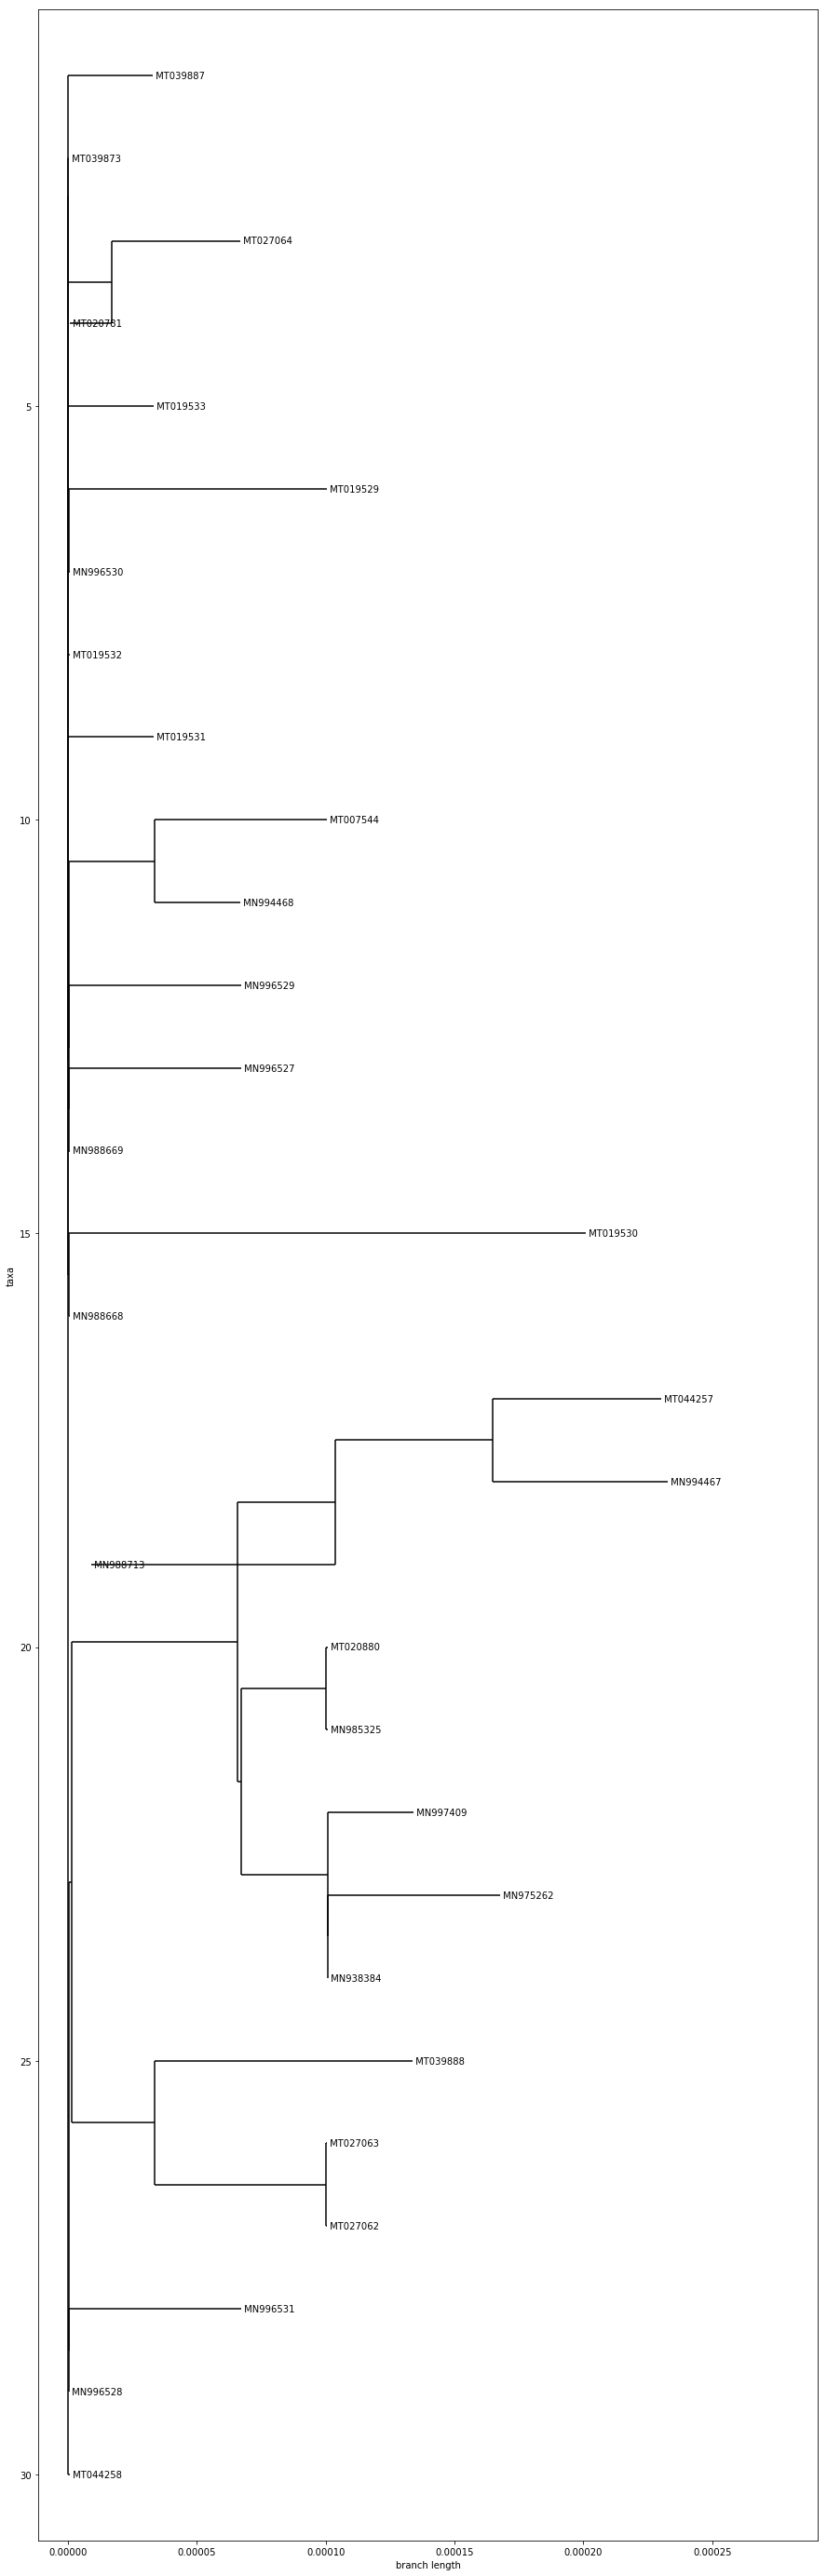

In [12]:
plt.rcParams['figure.figsize'] = [15, 50] 
phylo.draw( tree )

In [14]:
def root_to_tip( tree, date_df ):
    accum = []
    def tree_walker( clade, total_branch_length ):
        for child in clade.clades:
            if child.is_terminal:
                if child.name is not None:
                    date = date_df[date_df['Accession']==child.name]['Collection_Date'].to_string(index=False)
                    accum.append( ( child.name, date, total_branch_length + child.branch_length ) )
            tree_walker( child, total_branch_length + child.branch_length  )
    tree_walker( tree.clade, 0 )
    return pd.DataFrame( accum, columns=["name","date","distance_to_root"] )

In [15]:
for clade in list( tree.find_clades() ):
    tree.root_with_outgroup( clade )
    df = root_to_tip( tree, col_dates )
    df['date'] = pd.to_datetime(df['date']) 
    df['date_as_numeric'] = [d.year + (d.dayofyear-1)/365 for d in df['date']]

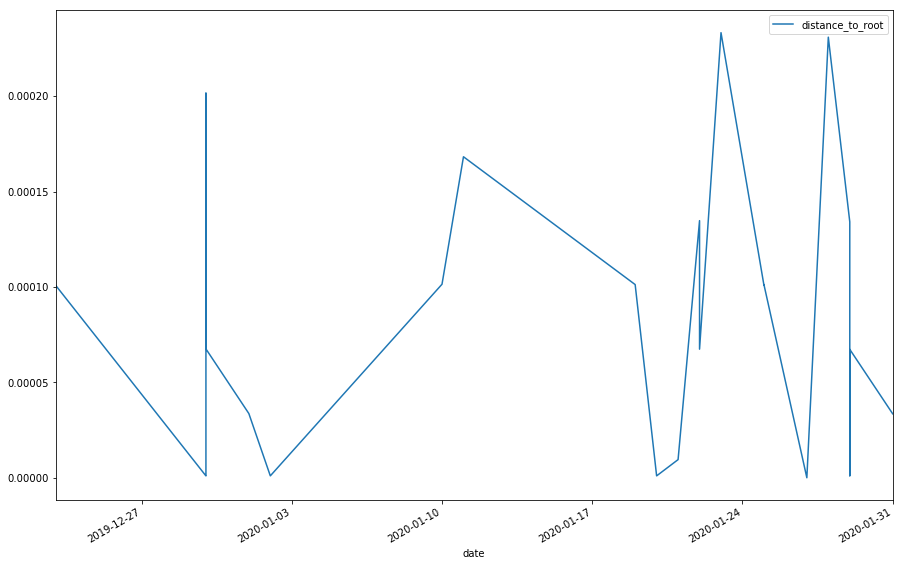

In [16]:
plt.rcParams['figure.figsize'] = [15, 10] 
df.plot( x="date", y="distance_to_root" )

In [17]:
df['date_as_numeric'] = [d.year + (d.dayofyear-1)/365 for d in df['date']]

## MRCA timing is ...

In [19]:
import datetime
def decimal_to_calendar (decimal):
    years = int (decimal)
    d = datetime.datetime (years, 1,1) + datetime.timedelta (days = int ((decimal-years)*365))
    return d

model = smf.ols(formula='distance_to_root ~ date_as_numeric ', data=df)
results = model.fit()
print( results.summary() )
print ("Root predicted at {}".format(decimal_to_calendar(-results.params.Intercept/results.params.date_as_numeric)))

                            OLS Regression Results                            
Dep. Variable:       distance_to_root   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.671
Date:                Thu, 13 Feb 2020   Prob (F-statistic):              0.207
Time:                        19:40:50   Log-Likelihood:                 246.10
No. Observations:                  30   AIC:                            -488.2
Df Residuals:                      28   BIC:                            -485.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.9146      0.708     